# nbeats seq2seq 'Yearly' 적합 모델 예제

####  밑의 소스코드를 활용한 seq2seq yearly 모델 구현예제
- 다른 계절성 패턴과 lookback, loss 함수등의 여러 앙상블은 구현하지 않은 단편 모델
- 데이터 구현 : https://github.com/ServiceNow/N-BEATS/tree/master
- 모델 아키텍쳐 : https://github.com/philipperemy/n-beats


---

In [95]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

## m4data

In [8]:

import logging
import os
import pathlib
import sys
from urllib import request

def download(url: str, file_path: str) -> None:
    """
    Download a file to the given path.

    :param url: URL to download
    :param file_path: Where to download the content.
    """

    def progress(count, block_size, total_size):
        progress_pct = float(count * block_size) / float(total_size) * 100.0
        sys.stdout.write('\rDownloading {} to {} {:.1f}%'.format(url, file_path, progress_pct))
        sys.stdout.flush()

    if not os.path.isfile(file_path):
        opener = request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        request.install_opener(opener)
        pathlib.Path(os.path.dirname(file_path)).mkdir(parents=True, exist_ok=True)
        f, _ = request.urlretrieve(url, file_path, progress)
        sys.stdout.write('\n')
        sys.stdout.flush()
        file_info = os.stat(f)
        logging.info(f'Successfully downloaded {os.path.basename(file_path)} {file_info.st_size} bytes.')
    else:
        file_info = os.stat(file_path)
        logging.info(f'File already exists: {file_path} {file_info.st_size} bytes.')


def url_file_name(url: str) -> str:
    """
    Extract file name from url.

    :param url: URL to extract file name from.
    :return: File name.
    """
    return url.split('/')[-1] if len(url) > 0 else ''
"""
M4 Dataset
"""
import logging
import os
from collections import OrderedDict
from dataclasses import dataclass
from glob import glob

import numpy as np
import pandas as pd
#import patoolib
from tqdm import tqdm

#from common.http_utils import download, url_file_name
#from common.settings import DATASETS_PATH


STORAGE=os.getenv('STORAGE')
DATASETS_PATH=os.path.join(STORAGE, 'datasets')
EXPERIMENTS_PATH=os.path.join(STORAGE, 'experiments')
TESTS_STORAGE_PATH=os.path.join(STORAGE, 'test')
FREQUENCIES = ['Hourly', 'Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly']
URL_TEMPLATE = 'https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/{}/{}-{}.csv'

TRAINING_DATASET_URLS = [URL_TEMPLATE.format("Train", freq, "train") for freq in FREQUENCIES]
TEST_DATASET_URLS = [URL_TEMPLATE.format("Test", freq, "test") for freq in FREQUENCIES]
INFO_URL = 'https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv'
NAIVE2_FORECAST_URL = 'https://github.com/M4Competition/M4-methods/raw/master/Point%20Forecasts/submission-Naive2.rar'

DATASET_PATH = os.path.join(DATASETS_PATH, 'm4')

TRAINING_DATASET_FILE_PATHS = [os.path.join(DATASET_PATH, url_file_name(url)) for url in TRAINING_DATASET_URLS]
TEST_DATASET_FILE_PATHS = [os.path.join(DATASET_PATH, url_file_name(url)) for url in TEST_DATASET_URLS]
INFO_FILE_PATH = os.path.join(DATASET_PATH, url_file_name(INFO_URL))
NAIVE2_FORECAST_FILE_PATH = os.path.join(DATASET_PATH, 'submission-Naive2.csv')


TRAINING_DATASET_CACHE_FILE_PATH = os.path.join(DATASET_PATH, 'training.npz')
TEST_DATASET_CACHE_FILE_PATH = os.path.join(DATASET_PATH, 'test.npz')


@dataclass()
class M4Dataset:
    ids: np.ndarray
    groups: np.ndarray
    frequencies: np.ndarray
    horizons: np.ndarray
    values: np.ndarray

    @staticmethod
    def load(training: bool = True) -> 'M4Dataset':
        """
        Load cached dataset.

        :param training: Load training part if training is True, test part otherwise.
        """
        m4_info = pd.read_csv(INFO_FILE_PATH)
        return M4Dataset(ids=m4_info.M4id.values,
                         groups=m4_info.SP.values,
                         frequencies=m4_info.Frequency.values,
                         horizons=m4_info.Horizon.values,
                         values=np.load(
                             TRAINING_DATASET_CACHE_FILE_PATH if training else TEST_DATASET_CACHE_FILE_PATH,
                             allow_pickle=True))

    @staticmethod
    def download() -> None:
        """
        Download M4 dataset if doesn't exist.
        """
        if os.path.isdir(DATASET_PATH):
            logging.info(f'skip: {DATASET_PATH} directory already exists.')
            return

        download(INFO_URL, INFO_FILE_PATH)
        m4_ids = pd.read_csv(INFO_FILE_PATH).M4id.values

        def build_cache(files: str, cache_path: str) -> None:
            timeseries_dict = OrderedDict(list(zip(m4_ids, [[]] * len(m4_ids))))
            logging.info(f'Caching {files}')
            for train_csv in tqdm(glob(os.path.join(DATASET_PATH, files))):
                dataset = pd.read_csv(train_csv)
                dataset.set_index(dataset.columns[0], inplace=True)
                for m4id, row in dataset.iterrows():
                    values = row.values
                    timeseries_dict[m4id] = values[~np.isnan(values)]
            np.array(list(timeseries_dict.values())).dump(cache_path)

        for url, path in zip(TRAINING_DATASET_URLS, TRAINING_DATASET_FILE_PATHS):
            download(url, path)
        build_cache('*-train.csv', TRAINING_DATASET_CACHE_FILE_PATH)

        for url, path in zip(TEST_DATASET_URLS, TEST_DATASET_FILE_PATHS):
            download(url, path)
        build_cache('*-test.csv', TEST_DATASET_CACHE_FILE_PATH)

        naive2_archive = os.path.join(DATASET_PATH, url_file_name(NAIVE2_FORECAST_URL))
        download(NAIVE2_FORECAST_URL, naive2_archive)
        patoolib.extract_archive(naive2_archive, outdir=DATASET_PATH)


@dataclass()
class M4Meta:
    seasonal_patterns = ['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']
    horizons = [6, 8, 18, 13, 14, 48]
    frequencies = [1, 4, 12, 1, 1, 24]
    horizons_map = {
        'Yearly': 6,
        'Quarterly': 8,
        'Monthly': 18,
        'Weekly': 13,
        'Daily': 14,
        'Hourly': 48
    }
    frequency_map = {
        'Yearly': 1,
        'Quarterly': 4,
        'Monthly': 12,
        'Weekly': 1,
        'Daily': 1,
        'Hourly': 24
    }

def load_m4_info() -> pd.DataFrame:
    """
    Load M4Info file.

    :return: Pandas DataFrame of M4Info.
    """
    return pd.read_csv(INFO_FILE_PATH)

In [52]:
train = M4Dataset.load(training=True)
test = M4Dataset.load(training=False)

---

## data 전처리

In [29]:
def group_values(values: np.ndarray, groups: np.ndarray, group_name: str) -> np.ndarray:
    """
    Filter values array by group indices and clean it from NaNs.

    :param values: Values to filter.
    :param groups: Timeseries groups.
    :param group_name: Group name to filter by.
    :return: Filtered and cleaned timeseries.
    """
    return [v[~np.isnan(v)] for v in values[groups == group_name]]

In [37]:
M4Meta.seasonal_patterns

['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']

In [60]:
# 계절성분별로 m4데이터 리스트로 분할
group_train= [group_values(train.values, train.groups, M4Meta.seasonal_patterns[i]) for i in range(len(M4Meta.seasonal_patterns))]
group_test= [group_values(test.values, test.groups, M4Meta.seasonal_patterns[i]) for i in range(len(M4Meta.seasonal_patterns))]

In [16]:
"""
Timeseries sampler
"""
import numpy as np

#import gin

#@gin.configurable
class TimeseriesSampler:
    def __init__(self,
                 timeseries: np.ndarray,
                 insample_size: int,
                 outsample_size: int,
                 window_sampling_limit: int,
                 batch_size: int = 1024):
        """
        Timeseries sampler.

        :param timeseries: Timeseries data to sample from. Shape: timeseries, timesteps
        :param insample_size: Insample window size. If timeseries is shorter then it will be 0-padded and masked.
        :param outsample_size: Outsample window size. If timeseries is shorter then it will be 0-padded and masked.
        :param window_sampling_limit: Size of history the sampler should use.
        :param batch_size: Number of sampled windows.
        """
        self.timeseries = [ts for ts in timeseries]
        self.window_sampling_limit = window_sampling_limit
        self.batch_size = batch_size
        self.insample_size = insample_size
        self.outsample_size = outsample_size

    def __iter__(self):
        """
        Batches of sampled windows.

        :return: Batches of:
         Insample: "batch size, insample size"
         Insample mask: "batch size, insample size"
         Outsample: "batch size, outsample size"
         Outsample mask: "batch size, outsample size"
        """
        while True:
            insample = np.zeros((self.batch_size, self.insample_size))
            insample_mask = np.zeros((self.batch_size, self.insample_size))
            outsample = np.zeros((self.batch_size, self.outsample_size))
            outsample_mask = np.zeros((self.batch_size, self.outsample_size))
            sampled_ts_indices = np.random.randint(len(self.timeseries), size=self.batch_size)
            for i, sampled_index in enumerate(sampled_ts_indices):
                sampled_timeseries = self.timeseries[sampled_index]
                cut_point = np.random.randint(low=max(1, len(sampled_timeseries) - self.window_sampling_limit),
                                              high=len(sampled_timeseries),
                                              size=1)[0]

                insample_window = sampled_timeseries[max(0, cut_point - self.insample_size):cut_point]
                insample[i, -len(insample_window):] = insample_window
                insample_mask[i, -len(insample_window):] = 1.0
                outsample_window = sampled_timeseries[
                                   cut_point:min(len(sampled_timeseries), cut_point + self.outsample_size)]
                outsample[i, :len(outsample_window)] = outsample_window
                outsample_mask[i, :len(outsample_window)] = 1.0
            yield insample, insample_mask, outsample, outsample_mask

    def last_insample_window(self):
        """
        The last window of insample size of all timeseries.
        This function does not support batching and does not reshuffle timeseries.

        :return: Last insample window of all timeseries. Shape "timeseries, insample size"
        """
        insample = np.zeros((len(self.timeseries), self.insample_size))
        insample_mask = np.zeros((len(self.timeseries), self.insample_size))
        for i, ts in enumerate(self.timeseries):
            ts_last_window = ts[-self.insample_size:]
            insample[i, -len(ts):] = ts_last_window
            insample_mask[i, -len(ts):] = 1.0
        return insample, insample_mask

In [61]:
# group_train[0] -> 년간 시계열
train_x =TimeseriesSampler(group_train[0],10,3,1)
test_y =TimeseriesSampler(group_test[0],10,3,1)

In [122]:
# X의 인풋사이즈 설정
# data의 길이가 인풋사이즈보다 작을때 문제점있음
lookback = np.array([2,3,4,5,6,7])
horizon = M4Meta.horizons_map['Yearly']
inputsize = lookback[0]*horizon
inputsize

12

In [123]:
X = np.array([train_x.timeseries[i][-inputsize:] for i in range(len(train_x.timeseries))])
y = np.array([test_y.timeseries[i] for i in range(len(test_y.timeseries))])

In [125]:
X.shape ,y.shape

((23000, 12), (23000, 6))

In [126]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X_scale= minmax.fit_transform(X)
y_scale=minmax.fit_transform(y)

---

## nbeats 모델 구현
- **하이퍼파라미터는 최대한 논문과 유사하게 설정**
- 앙상블은 아직 진행하지 않음
- yearly에대한 단편적인 예측 모형
- 단 데이터에 대한 scaling은 진행하였음

In [135]:
input_dim, output_dim =  1, 1
backcast=inputsize
forecast = M4Meta.horizons_map['Yearly']


K.clear_session()
model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(2,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )
model.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 12, 1)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 12)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/trend/d1 (Dense)           (None, 128)          1664        ['lambda[0][0]',                 
                                                                  'subtract[0][0]',               
                                                                  'subtract_1[0][0]',             
                                                                  'subtract_2[0][0]']      

In [136]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model.fit(X_scale,y_scale,
                    epochs=100, batch_size=512,
                    callbacks=[early_stop])

Epoch 1/100
45/45 [==============================] - 8s 90ms/step - loss: 0.0019
Epoch 2/100
45/45 [==============================] - 5s 121ms/step - loss: 2.6521e-04
Epoch 3/100
45/45 [==============================] - 7s 152ms/step - loss: 1.6497e-04
Epoch 4/100
45/45 [==============================] - 7s 156ms/step - loss: 1.6347e-04
Epoch 5/100
45/45 [==============================] - 7s 152ms/step - loss: 1.5178e-04
Epoch 6/100
45/45 [==============================] - 7s 152ms/step - loss: 1.6821e-04
Epoch 7/100
45/45 [==============================] - 7s 152ms/step - loss: 1.4470e-04
Epoch 8/100
45/45 [==============================] - 7s 151ms/step - loss: 1.4328e-04
Epoch 9/100
45/45 [==============================] - 7s 152ms/step - loss: 1.4262e-04
Epoch 10/100
45/45 [==============================] - 7s 152ms/step - loss: 1.5707e-04
Epoch 11/100
45/45 [==============================] - 7s 153ms/step - loss: 1.3834e-04
Epoch 12/100
45/45 [==============================] - 7s 

719/719 [==============================] - 2s 3ms/step


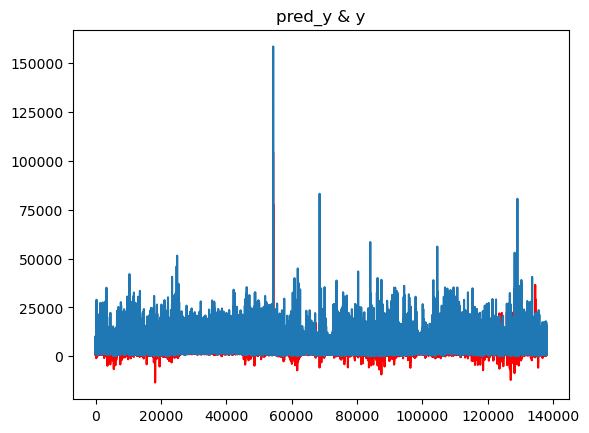

In [149]:
pred = model.predict(X)
plt.plot(pred.flatten(), color='red')
plt.plot(y.flatten())
plt.title('pred_y & y')
plt.show()

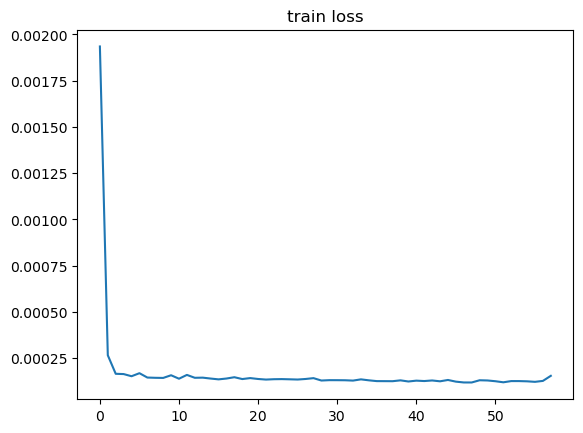

In [147]:
plt.plot(history.history['loss'])
plt.title('train loss')
plt.show()